In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torchvision
import torch.nn as nn

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
from advertorch.test_utils import LeNet5
from advertorch_examples.utils import TRAINED_MODEL_PATH

filename = "mnist_lenet5_clntrained.pt"
# filename = "mnist_lenet5_advtrained.pt"

model = LeNet5()
model.load_state_dict(
    torch.load(os.path.join(TRAINED_MODEL_PATH, filename)))
model.to(device)
model.eval()

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [37]:
batch_size = 3

ds_train10 = torchvision.datasets.MNIST('./data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]));
#test数据集
ds_test10 = torchvision.datasets.MNIST('./data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))

train_loader10 = torch.utils.data.DataLoader(
    ds_train10,
  batch_size=batch_size, shuffle=True)

test_loader10 = torch.utils.data.DataLoader(
    ds_test10,
  batch_size=batch_size, shuffle=True)

for cln_data, true_label in train_loader10:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [38]:
from advertorch.attacks import LinfPGDAttack

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.1, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

In [39]:
adv_untargeted = adversary.perturb(cln_data, true_label)

In [40]:
target = torch.ones_like(true_label) * 3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

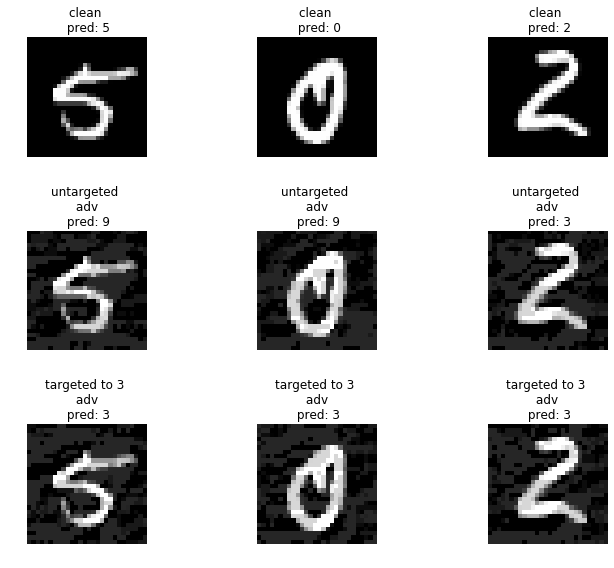

In [41]:

pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
pred_targeted_adv = predict_from_logits(model(adv_targeted))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(
        pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()